# Klausur

## Task 1

In [21]:
using Plots
using FFTW
using LaTeXStrings
using Distributed
using ProgressMeter
using Profile

## Task 4

In [59]:
"""
Computes gradient of a 2D scalar field.

`T` is a scalar field in direct space.

Returns a vector field in direct space.
"""
function f_grad(T,Nx, Ny, Lx, Ly)
    T = real(ifft(T))
    diff_x = fill(0.0, (Nx,Ny))
    diff_y = fill(0.0, (Nx,Ny))


    # Derivative in x direction
    for i in 1:size(T,2)
        diff_x[:,i] = f_diff(T[:,i],Nx,Lx)
    end

    # Derivative in y direction
    for i in 1:size(T,1)
        diff_y[i,:] = f_diff(T[i,:],Ny,Ly)
    end

    return [diff_x,diff_y]
end

"""
Applies laplace operator onto scalar field `T`.

`T` is a scalar field in direct space.

Returns scalar field in direct space.
"""
function laplace(T, Nx, Ny, Lx, Ly)
    diff_x = fill(0.0, (Nx,Ny))
    diff_y = fill(0.0, (Nx,Ny))
    diff = fill(0.0, (Nx,Ny))
    grad = f_grad(T, Nx, Ny, Lx, Ly)

    # Derivative in x direction
    for i in 1:size(T,2)
        diff_x[:,i] = f_diff(getindex.(grad,1)[:,i],Nx,Lx)
    end

    # Derivative in y direction
    for i in 1:size(T,1)
        diff_y[i,:] = f_diff(getindex.(grad,2)[i,:],Ny,Ly)
    end

    # Sums derivatives in x and y
    for i in 1:size(T,1)
        for j in 1:size(T,2)
            diff[i,j] = diff_x[i,j] + diff_y[i,j]
        end
    end

    return diff
end

"""
Differentiates `x` in fourier space.

`x` is a 1d array.

Returns real part of the inverse fourier transform.
"""
function f_diff(x,N,L)
    k = fftfreq(N)*N
    diff = ifft(2*pi*im/L*k.*fft(x))
    return real(diff)
end


"""
Returns real fourier coeffs of v⋅∇T.

`v` is a vector field in direct space.

`T` is a scalar field in direct space.

"""
function v∇T(v,T,Nx,Ny,Lx,Ly)
    ∇T = f_grad(T,Nx,Ny,Lx,Ly)
    return fft(v[1].*∇T[1] .+ v[2].*∇T[2])
end

"Computes the element-wise scalar product of two vector fields"
function scalarProductVecField(a,b)
    return getindex.(a,1).*getindex.(b,1) + getindex.(a,2).*getindex.(b,2)
end

"Source term Q in direct space"
function sourceTerm(x,y)
    return -2*pi^2*sin(4*pi*x)*cos(2*pi*y)*sin(2*pi*x)*sin(2*pi*y) - 4*pi^2*cos(4*pi*x)*sin(2*pi*y)*cos(2*pi*x)*cos(2*pi*y) + 8*pi^2*cos(2*pi*x)*sin(2*pi*y)
end

"Source term Q in fourier space"
function Q_hat(Nx,Ny,Lx,Ly)
    Q = fill(0.0,Nx,Ny)
    for i in 1:Nx
        for j in 1:Ny
            Q[i,j] = sourceTerm(Lx/(Nx)*(i),Ly/(Ny)*(j))
        end
    end
    return fft(Q)
end

"""
Time step for the integration of the temperature field.
`T_hist` is the temperature field in fourier space.

`v_hist` is the velocity field in fourier space.

`hats` is an array of prevoiusly calculated v⋅∇T.

Returns new temperature field in fourier space.
"""
function T_step(T,hat,hat_old,Nx,Ny,Lx,Ly,Δt,Q)
    # Wave Vectors #
    kx = 2*pi*fftfreq(Nx)*Nx/Lx
    ky = 2*pi*fftfreq(Ny)*Ny/Ly

    #T_new = Matrix{ComplexF64}(undef, Nx, Ny)
   
    for i in 1:size(T,1)
        for j in 1:size(T,2)
            T[i,j] = 1/(1+Δt*0.5*(kx[i]^2+ky[j]^2))*(T[i,j]+Δt*(-0.5*(kx[i]^2+ky[j]^2)*T[i,j]-0.5*(3*hat[i,j]-hat_old[i,j])+Q[i,j]))
        end
    end
    
    return T
end


T_step

In [60]:
"Calculates the sum of the elementwise absolute diffrence between two scalar fields"
function abs_change(a,b)
    diff = a - b
    change = sum(abs.(diff))
    return change
end

"Initial velocity vector field"
function velocity(Nx,Ny,Lx,Ly)
    v = Vector{Matrix{Float64}}
    v = [zeros(Float64,Nx,Ny),zeros(Float64,Nx,Ny)]
    for i in 1:Nx
        for j in 1:Ny
            v[1][i,j] = pi*sin(4*pi*(Lx/(Nx))*(i))*cos(2*pi*(Ly/(Ny))*((j)))
            v[2][i,j] = -2*pi*cos(4*pi*(Lx/(Nx))*(i))*sin(2*pi*(Ly/(Ny))*((j)))
        end
    end
    return v
end

function target_T(Nx,Ny,Lx,Ly)
    target = fill(0.0, (Nx,Ny))
    for i in 1:Nx
        for j in 1:Ny
            target[i,j] = cos(2.0*pi*Lx/Nx*i)*sin(2*pi*Ly/Ny*j)
        end
    end
    return target
end

target_T (generic function with 1 method)

## Task 5

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


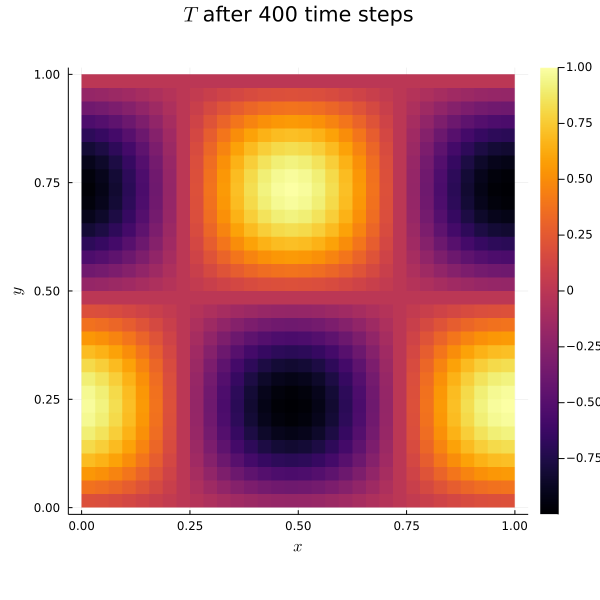

0.9999999999999915

In [62]:
"""
Integrates the temperature field `T` with an initial velocity field `v` for `steps` steps with timestep `timestep`.

Returns an array containing all calculated temperature fields in fourier space.
"""
function integrate(geometry,timestep,steps,v,T,Q,dynamic=false)
    Nx = geometry[1][1]
    Ny = geometry[1][2]
    Lx = geometry[2][1]
    Ly = geometry[2][2]


    T_hist = [fft(copy(T)),fft(copy(T))]
    v_hist = [copy(v)]
    
    hat_old = v∇T(v_hist[end],T_hist[end - 1],Nx,Ny,Lx,Ly)

    @showprogress for i in 1:steps

        # Calculate ℱ(v⋅∇T) #
        hat = v∇T(v_hist[end],T_hist[end],Nx,Ny,Lx,Ly)
        

        push!(T_hist,T_step(T_hist[end],hat,hat_old,Nx,Ny,Lx,Ly,timestep,Q))

        
        hat_old = hat

        # Update velocity field #
        if dynamic
            v = update_velocity(T_hist[end],v,Nx,Ny,Lx,Ly)
            push!(v_hist,v)
        end
    end
    #display(heatmap(getindex.(v_hist[end],1)))
    #display(heatmap(getindex.(v_hist[end],2)))
    return T_hist
end

function scalar_2_vector(a,b)
    Nx = size(a,1)
    Ny = size(a,2)
    v = Matrix{Vector{ComplexF64}}(undef, Nx, Ny)
    for i in 1:Nx
        for j in 1:Ny
            v[i,j] = copy([0.0,0.0])
            v[i,j][1] = a[i,j]
            v[i,j][2] = b[i,j]
        end
    end
    return v
end

function test_function(mode)
    Nx = 32
    Ny = 32
    Lx = 1.0
    Ly = 1.0

    geometry = ((Nx,Ny),(Lx,Ly))
    timestep = 0.001
    steps = 400
    
        # Initial temperature field #
        T = fill(0.0, (Nx,Ny))
        for i in 1:Nx
            for j in 1:Ny
                T[i,j] = 0
            end
        end
    

    if mode == "gif"
        anim = @animate for h in integrate(geometry,timestep,steps,velocity(Nx,Ny,Lx,Ly),T,Q_hat(Nx,Ny,Lx,Ly))
            #heatmap(real(ifft(h)),c= :magma)
            heatmap(real(ifft(h)))
        end every 100
        display(gif(anim, "heatmap.gif",fps=15))
    end


    # Plot maximum temperature to find stationaty solution #
    if mode == "max"
        maxx = []
        for h in integrate(geometry,timestep,steps,velocity(Nx,Ny,Lx,Ly),T,Q_hat(Nx,Ny,Lx,Ly))
            append!(maxx,maximum(real(ifft(h))))
        end
        display(plot(maxx))
    end
    Q = Q_hat(Nx,Ny,Lx,Ly)
    if mode == "v"
        # Initial velocity field #
        v = Matrix{Vector{Float64}}(undef, Nx, Ny)
        for i in 1:Nx
            for j in 1:Ny
                v[i,j] = copy([0.0,0.0])
                v[i,j][1] = pi*sin(4*pi*(Lx/(Nx))*(i))*cos(2*pi*(Ly/(Ny))*((j)))
                v[i,j][2] = -2*pi*cos(4*pi*(Lx/(Nx))*(i))*sin(2*pi*(Ly/(Ny))*((j)))
            end
        end
        #v[1,1][1] = 50
        plotx = heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),getindex.(v',1),title=L"$\vec{v}_y$",xlabel=L"$x$",ylabel=L"$y$",aspect_ratio=:equal,clim = (-5, 5))
        ploty = heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),getindex.(v',2),title=L"$\vec{v}_x$",xlabel=L"$x$",ylabel=L"$y$",aspect_ratio=:equal,clim = (-5, 5))
        display(plot(ploty,plotx,size=(800,400),link=:all,layout=(1,2),sharey = true, legend=:none))
    end

    if mode == "roc"
        cc = []
        t_max = 1
        timesteps = [0.01 0.05 0.1]
        plt_absolute = plot()
        plt_change = plot()
        for i in timesteps'
            diff_t_star = []
            change = []
            steps = floor(t_max/i)
            T_hist = integrate(geometry,i,steps,velocity(Nx,Ny,Lx,Ly),T,Q_hat(Nx,Ny,Lx,Ly))
            for i in 2:length(T_hist)
                push!(change,abs_change(real(ifft(T_hist[i])),real(ifft(T_hist[i-1]))))
                push!(diff_t_star,sum(abs.(real(ifft(T_hist[i])) - target_T(Nx,Ny,Lx,Ly)))) 
            end
            plt_change = plot!(plt_change,(0:i:steps*i),change,label=L"$\Delta t = $" .* string.(i),ylim=(0,100),xlabel="Time",ylabel=L"$\sum_{ij}\vert T_{ij}^n-T_{ij}^{n-1}\vert$",title=L"Absolute difference between $T^{n}$ and $T^{n-1}$")
            plt_absolute = plot!(plt_absolute,(0:i:steps*i),diff_t_star,label=L"$\Delta t = $" .* string.(i),ylim=(0,500),xlabel="Time",ylabel=L"$\vert T^\star- T^n \vert$",title=L"Absolute difference between $T^\star$ and $T^{n}$")
            #push!(cc,plot((0:i:steps*i),c,label=L"$\Delta t = $" .* string.(i),ylim=(0,100),xlabel="Timesteps",ylabel=L"$\sum_{ij}\vert T_{ij}^n-T_{ij}^{n-1}\vert$"))


        end
        display(plot(plt_absolute))
    end


    #Sum of the absolute diffrence between temperature field $T^n$ and $T^{n-1}$
    if mode == "Q"
        display(heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),real(ifft(Q))',title=L"Source term $Q^\star$",aspect_ratio=:equal,xlabel=L"$x$",ylabel=L"$y$",size=(600,600)))
        #Q_NEW = fft(real(ifft(Q)))

        #display(heatmap(real(ifft(Q_NEW))))
    end

    if mode == "final"
        T = real(ifft(integrate(geometry,timestep,steps,velocity(Nx,Ny,Lx,Ly),T,Q_hat(Nx,Ny,Lx,Ly))[end]))'
        display(heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),T,title=L"$T$ after " * string(steps) * " time steps",aspect_ratio=:equal,xlabel=L"$x$",ylabel=L"$y$",size=(600,600)))
        print(maximum(T))
    end

    if mode == "test"
        T = real(ifft(integrate(geometry,timestep,steps,velocity(Nx,Ny,Lx,Ly),T,Q_hat(Nx,Ny,Lx,Ly))[end]))
        v = velocity(Nx,Ny,Lx,Ly)

        OO = real(ifft(v∇T(v,T,Nx,Ny,Lx,Ly))) - laplace(T,Nx,Ny,Lx,Ly) - real(ifft(Q))
        
        display(heatmap(target_T(Nx,Ny,Lx,Ly) - T,aspect_ratio=:equal,right_margin = 10Plots.mm))
        #display(heatmap(target_T(Nx,Ny,Lx,Ly) - T,aspect_ratio=:equal,right_margin = 10Plots.mm))
    end
end
test_function("final")



## Task 6

In [63]:
"""
Updates the velocity field for a given `T` in fourier space.

Returns velocity vector field in fourier space. 
"""
function update_velocity(T,v,Nx,Ny,Lx,Ly)
    kx = 2*pi*fftfreq(Nx)*Nx/Lx
    ky = 2*pi*fftfreq(Ny)*Ny/Ly
    k_abs = kx.^2 .+ (ky.^2)'
    Ra = 1e9
    for i in 1:Nx
        for j in 1:Ny
            if k_abs[i,j] != 0
                v[1][i,j] = ((-kx[i]*ky[j]/k_abs[i,j])*T[i,j]*Ra)/(k_abs[i,j])
                v[2][i,j] = ((-ky[j]*ky[j]/k_abs[i,j] + 1)*T[i,j]*Ra)/(k_abs[i,j])
            else
                v[1][i,j] = 0.0
                v[2][i,j] = 0.0
            end
        end
    end
    v[1] = real(ifft(v[1]))
    v[2] = real(ifft(v[2]))
    return v
end

function test_v_update()
    Nx = 32
    Ny = 32
    Lx = 1.0
    Ly = 1.0
    vx = real(ifft(getindex.(update_velocity(fft(target_T(Nx,Ny,Lx,Ly)),Nx,Ny,Lx,Ly),1)))
    vy = real(ifft(getindex.(update_velocity(fft(target_T(Nx,Ny,Lx,Ly)),Nx,Ny,Lx,Ly),2)))
    
    #vx,vy = normalize(vx,vy)
    
    xs = 1:Nx
    ys = 1:Ny
    
    xxs = [x for x in xs for y in ys]
    yys = [y for x in xs for y in ys]
    
    
    
    heatmap(xs,ys,target_T(Nx,Ny,Lx,Ly)')
    #GRUtils.quiver(x,y,vy,vx)
    #GRUtils.heatmap(target_T(Nx,Ny,Lx,Ly))
    heatmap(vy)
    #Plots.quiver!(vec(xxs),vec(yys),quiver=(vec(vx'),vec(vy')),color=:white,title=L"Velocity field resulting from temperature distibution $T^\star$",xlabel=L"$x$",ylabel=L"$y$")    
end
#test_v_update()

test_v_update (generic function with 1 method)

In [64]:
function source_distribution(i,j,Nx,Ny,Lx,Ly,σ)
    x = Lx/Nx * i
    y = Ly/Ny * j
    return 1/(2*pi*σ^2)*exp(-((x-0.5*Lx)^2 + y^2)/(2*σ^2))
end


source_distribution (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


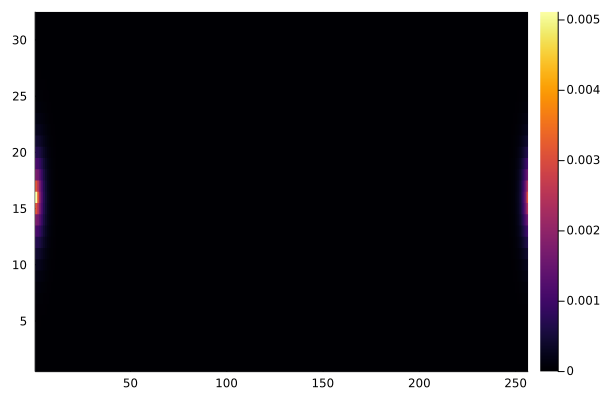

In [67]:
Nx = 32
Ny = 8*Nx
Lx = 1.0
Ly = 8*Lx

geometry = ((Nx,Ny),(Lx,Ly))
timestep = 1e-7
steps = 1000

# Initial temperature field #
T = fill(0.0, (Nx,Ny))
for i in 1:Nx
    for j in 1:Ny
        T[i,j] = 0
    end
end

v = Vector{Matrix{Float64}}
v = [Matrix{ComplexF64}(undef, Nx, Ny),Matrix{ComplexF64}(undef, Nx, Ny)]

for i in 1:Nx
    for j in 1:Ny
        v[1][i,j] = 0.0
        v[2][i,j] = 0.0
    end
end

Q = fill(0.0,Nx,Ny)
σ = 0.01
for i in 1:Nx
    for j in 1:Ny
        Q[i,j] = source_distribution(i,j,Nx,Ny,Lx,Ly,σ)
    end
end

Q_h = fft(Q)

Ts = integrate(geometry,timestep,steps,v,T,Q_h,true)
heatmap(real(ifft(Ts[end])))



In [45]:
Matrix{Vector{Float64}}(undef, Nx, Ny)


LoadError: TypeError: in Type, in parameter, expected Type, got a value of type Matrix{Float64}